In [27]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import datetime
import psycopg2
from sqlalchemy import create_engine
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def runQuery(query):

    cursor = connection.cursor()
    if "SELECT" in query:
        table = pd.read_sql(query, con = connection)
    elif "UPDATE" in query:
        cursor.execute(query)
        print(query)
        connection.commit()
    elif "DELETE" in query:
        cursor.execute(query)
        print(query)
        connection.commit()
    else:
        return None
    if connection:
        cursor.close()
        connection.close()
        if "SELECT" in query:
            return table
        else:
            return


data = runQuery("SELECT * FROM u01_suzanne_mitchell.wfu_master")


In [5]:
def qc_pedigree(data):
    data = data.sort_values(["cohort", "labanimalid"])
    # Printing number of mothers and fathers per cohort
    for cohort in np.unique(data["cohort"]):
        subset = data[data["cohort"] == cohort]
        sires = list(subset["sires"])
        dames = list(subset["dames"])
        print(cohort, "sires", "total", len(sires), "dups", len(set(sires)))
        print(cohort, "dames", "total", len(dames), "dups", len(set(dames)))
    # Printing animals listed as mother and father
    sires = list(data["sires"])
    dames = list(data["dames"])
    overlap = set(dames).intersection(set(sires))
    #print("sires", len(set(sires)), "dames", len(set(dames)), "overlap", len(overlap))
    print("listed as dame and sire", list(overlap))
    # Checking sibling numbers
    parents_dict = {}
    parents_litter_birth = {}
    dob = []
    litter = []
    parents_df = pd.DataFrame()
    for index, row in data.iterrows():
        parents = (row["sires"], row["dames"])
        
        if parents in parents_dict.keys():
            parents_dict[parents].append(row["rfid"])
            parents_litter_birth[parents].append(row["dob"])
        else:
            dob.append(row['dob'])
            litter.append(row['littersize'])
            parents_dict[parents] = [row["rfid"]]
            parents_litter_birth[parents] = [row["dob"]]
            parents_df = parents_df.append({'sires':row["sires"],'dames':row["dames"]},ignore_index = True)
    print("parent pairs", len(parents_dict.keys()))
    siblings = []
    for parents in parents_dict.keys():
        #print(parents, len(parents_dict[parents]))#, parents_dict[parents])
        siblings.append(len(parents_dict[parents]))
        cohorts = []
        for rfid in parents_dict[parents]:
            subset = data[data["rfid"] == rfid]
            subset.index = range(subset.shape[0])
            i_cohort = list(subset.columns).index("cohort")
            cohorts.append(subset.iloc[0, i_cohort])
        cohorts = list(np.unique(cohorts))
        if len(cohorts) != 1:
            print("parent pair across multiple cohorts found", cohorts)
    parents_df['siblings'] = siblings
    parents_df['dob'] = dob
    parents_df['litter_size'] = litter
    parents_df['removed_litter'] = parents_df['litter_size'] - parents_df['siblings']

    #print(parents_df)
    print(parents_df.litter_size.unique())
    print(data.littersize.unique())
    print(parents_df.removed_litter.unique())
    df_litter_error = parents_df[(parents_df['removed_litter'] <= 0)]
    print(parents_litter_birth)
    return
qc_pedigree(data)

C01 sires total 100 dups 34
C01 dames total 100 dups 34
C02 sires total 110 dups 44
C02 dames total 110 dups 44
C03 sires total 100 dups 40
C03 dames total 100 dups 40
C04 sires total 100 dups 48
C04 dames total 100 dups 48
C05 sires total 100 dups 51
C05 dames total 100 dups 51
C06 sires total 100 dups 50
C06 dames total 100 dups 50
C07 sires total 291 dups 99
C07 dames total 291 dups 99
listed as dame and sire ['nan']
parent pairs 396
parent pair across multiple cohorts found ['C01', 'C02']
parent pair across multiple cohorts found ['C01', 'C02']
parent pair across multiple cohorts found ['C01', 'C02']
parent pair across multiple cohorts found ['C01', 'C02']
parent pair across multiple cohorts found ['C01', 'C02']
parent pair across multiple cohorts found ['C02', 'C03']
parent pair across multiple cohorts found ['C02', 'C03']
parent pair across multiple cohorts found ['C04', 'C06']
parent pair across multiple cohorts found ['C04', 'C06']
parent pair across multiple cohorts found ['C0

In [6]:
#Split data based on cohorts
#each cohort has their own df named after their cohort. Ex. C07
cohorts = data.cohort.unique()
for i in cohorts:
    a = data[data.cohort == i]
    globals()[f"{i}"] = a
cohorts    

array(['C01', 'C04', 'C05', 'C02', 'C03', 'C06', 'C07'], dtype=object)

In [7]:
#Check that the dob for each cohort is within a certain range
#right now just outputs the cohort with the day span
dob_range = {}
for i in cohorts:
    globals()[f"dates_{i}"] = globals()[f"{i}"].dob.unique()
    oldest = min(globals()[f"dates_{i}"])
    youngest = max(globals()[f"dates_{i}"])
    difference = youngest - oldest
    dob_range[i] = difference
dob_range

{'C01': datetime.timedelta(days=11),
 'C04': datetime.timedelta(days=13),
 'C05': datetime.timedelta(days=13),
 'C02': datetime.timedelta(days=13),
 'C03': datetime.timedelta(days=13),
 'C06': datetime.timedelta(days=19),
 'C07': datetime.timedelta(days=71)}

In [8]:
#Check if there are any matching ids between sires and dames
unique_sires = data.sires.unique()
unique_dames = data.dames.unique()
print([x for x in unique_sires if x in unique_dames])


['nan']


In [9]:
#Check namiing of coat colors
unique_coats = data.coatcolor.unique()
unique_coats


array(['BROWNHOOD', 'ALBINO', 'BROWN', 'BLACK', 'BLACKHOOD'], dtype=object)

In [10]:
# Fixing coatcolor in sample_metadata
toFix = []
metadata = select_metadata()
# metadata = select_wfu_master("u01_olivier_george_oxycodone")
i_coatcolor = list(metadata.columns).index("coatcolor")
for index, row in metadata.iterrows():
    coatcolor = metadata.iloc[index, i_coatcolor]
    if coatcolor == "BLK HOOD":
        coatcolor = "BLACKHOOD"
    elif coatcolor == "BRN HOOD":
        coatcolor = "BROWNHOOD"
    elif coatcolor == "BEN HOOD":
        coatcolor = "BROWNHOOD"
    elif coatcolor == "ALIBINO":
        coatcolor = "ALBINO"
    coatcolor = coatcolor.replace(" ", "")
    if coatcolor != metadata.iloc[index, i_coatcolor]:
        toFix.append(index)
        metadata.iloc[index, i_coatcolor] = coatcolor
metadata = metadata.iloc[toFix, :]
metadata.index = range(metadata.shape[0])
metadata

NameError: name 'select_metadata' is not defined

In [ ]:
project_metadata = pd.read_csv("project_metadata - project_metadata.csv", dtype = str)
i_convention = list(project_metadata.columns).index("rfid_convention")
for project in projects:
    wfu_master = None
    if project in dontInclude:
        continue
    elif project in differentTableName.keys():
        table_name = project + "." + differentTableName[project]
        query = "SELECT * FROM " + table_name
        wfu_master = runQuery(query)
    else:
        wfu_master = select_wfu_master(project)
    subset = project_metadata[project_metadata["project_name"] == project]
    subset.index = range(subset.shape[0])
    convention_list = subset.iloc[0, i_convention]
    if isinstance(convention_list, float):
        continue
    convention_list = convention_list.split(";")
    for i in range(len(convention_list)):
        convention_list[i] = convention_list[i].replace("(", "").replace(")", "").split(",")
    for rfid in wfu_master["rfid"]:
        passed = False
        for convention in convention_list:
            prefix = convention[0]
            length = int(convention[1])
            passed = passed + qc_rfid(rfid, prefix, length)
        if not passed:
            print(rfid, project)

In [23]:
data['rfid'] = data['rfid'].astype(str)
data['last_5'] = data['rfid'].str.replace('9330003200','')
data['last_5'] = data['last_5'].str.replace('9330003201','')
data

,cohort,sires,dames,labanimalid,accessid,sex,rfid,dob,dow,shipmentdate,...,coatcolor,earpunch,rack,shipmentbox,housingbox,shipmentage,weanage,comments,resolution,last_5
0,C01,72539_1,72595_5,TJ008,73472_2,F,933000320045906,2018-09-24,2018-10-15,2018-10-30,...,BROWNHOOD,RB,D-F4,2.0,9999,36.0,21.0,Pregnant female/Impregnated,REMOVE_FROM_EXCLUSION_AND_REPLACE,45906
1,C01,73358_1,73360_1,TJ027,73477_2,F,933000320045890,2018-09-25,2018-10-16,2018-10-30,...,BROWNHOOD,LM,D-G8,4.0,32,35.0,21.0,NA,NA,45890
2,C01,72539_1,72595_5,TJ003,73472_8,M,933000320045902,2018-09-24,2018-10-15,2018-10-30,...,ALBINO,RT,D-F2,2.0,9999,36.0,21.0,Pregnant female/Impregnated,REMOVE_FROM_EXCLUSION_AND_REPLACE,45902
3,C01,72794_1,72775_4,TJ020,73475_4,F,933000320045904,2018-09-25,2018-10-16,2018-10-30,...,BROWN,RB,D-G2,2.0,9999,35.0,21.0,Pregnant female/Impregnated,REMOVE_FROM_EXCLUSION_AND_REPLACE,45904
4,C01,72624_1,72596_4,TJ002,73471_5,F,933000320045908,2018-09-23,2018-10-15,2018-10-30,...,BLACK,LT,D-F2,2.0,9999,37.0,22.0,Pregnant female/Impregnated,REMOVE_FROM_EXCLUSION_AND_REPLACE,45908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,C07,933000320048190,933000320187377,NA,None,F,933000320125436,2020-08-09,2020-09-04,None,...,BLACK,None,None,NaN,None,NaN,26.0,NA,NA,25436
897,C07,933000320187153,933000320187383,NA,None,F,933000320125437,2020-08-09,2020-09-04,None,...,BROWNHOOD,None,None,NaN,None,NaN,26.0,NA,NA,25437
898,C07,933000320187217,933000320048245,NA,None,F,933000320125440,2020-08-09,2020-09-04,None,...,BROWN,None,None,NaN,None,NaN,26.0,NA,NA,25440
899,C07,933000320187249,933000320048234,NA,None,M,933000320125443,2020-08-08,2020-09-04,None,...,BLACKHOOD,None,None,NaN,None,NaN,27.0,NA,NA,25443


In [25]:
data.housingbox.unique()

array(['9999', '32', '2', '9', '1', '3', '4', '5', '6', '7', '8', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '55', '54', '52', '51', '53',
       'NA', None], dtype=object)

In [24]:
data.to_csv(r'C:\Users\cocoy\Dropbox (Palmer Lab)\Palmer Lab\Shae Ziegler\Suzanne_Mitchell_U01\wfu_master.csv', index=False)

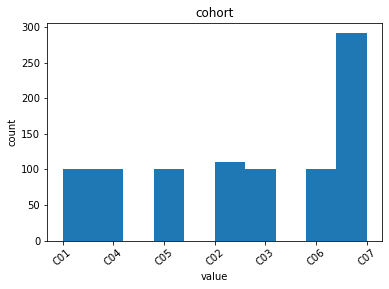

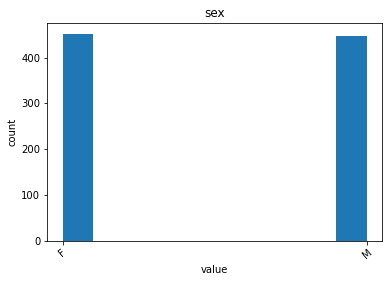

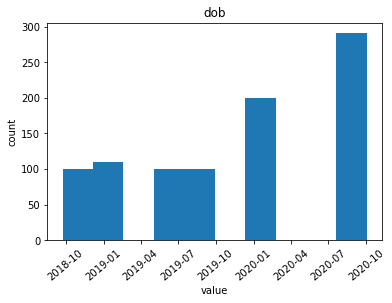

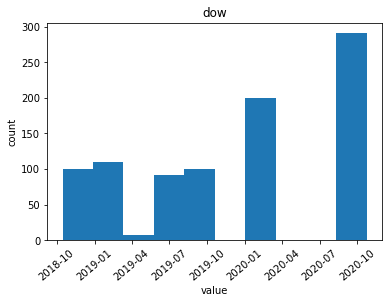

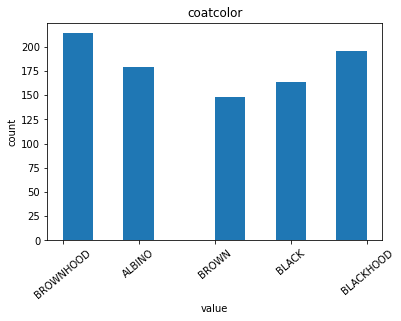

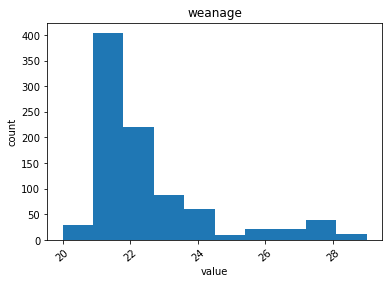

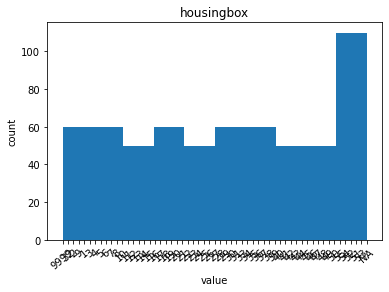

In [34]:
graph_columns = ['cohort','sex','dob','dow','coatcolor','weanage','housingbox']
for col in graph_columns:
    plt.title(col)
    plt.xlabel('value')
    plt.ylabel('count')
    plt.xticks(rotation = 40)
    plt.hist(data[col].dropna())
    plt.show() 